----------------------------------------EXPLORING STUDENT ALCOHOL CONSUMPTION-----------------------------------------

In [39]:
%matplotlib inline
#import modules to be used

import general_utils as Ugen
import pandas as pd
import numpy as np
from scipy import stats

from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_selection import f_regression

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)

In [2]:
##GET DATA
df=pd.read_csv('../student-mat.csv',delimiter=';')

In [3]:
##EXPLORE DATA
print (df.shape)
df.head() 

###see https://github.com/iwhitest/UD201 --> "STUDENT ALCOHOL CONSUMPTION Data Set.pdf" for variable descriptions

(395, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [4]:
##CONVERT BINARIES
df=df.replace(['yes','no','M','F','U','R','LE3','GT3','T','A','GP','MS'],[1,0,1,0,1,0,1,0,1,0,1,0])

##DROP CATEGORICAL COLUMNS
###can't use these in a linreg
df=df.drop(['Mjob','Fjob','reason','guardian'],axis=1)


In [5]:
df.head() ##check conversion; success

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,18,1,0,0,4,4,2,2,...,4,3,4,1,1,3,6,5,6,6
1,1,0,17,1,0,1,1,1,1,2,...,5,3,3,1,1,3,4,5,5,6
2,1,0,15,1,1,1,1,1,1,2,...,4,3,2,2,3,3,10,7,8,10
3,1,0,15,1,0,1,4,2,1,3,...,3,2,2,1,1,5,2,15,14,15
4,1,0,16,1,0,1,3,3,1,2,...,4,3,2,1,2,5,4,6,10,10


In [6]:
##PRINT VARIABLES
list(df.columns.values)

#target variables will be Walc & Dalc

['school',
 'sex',
 'age',
 'address',
 'famsize',
 'Pstatus',
 'Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences',
 'G1',
 'G2',
 'G3']

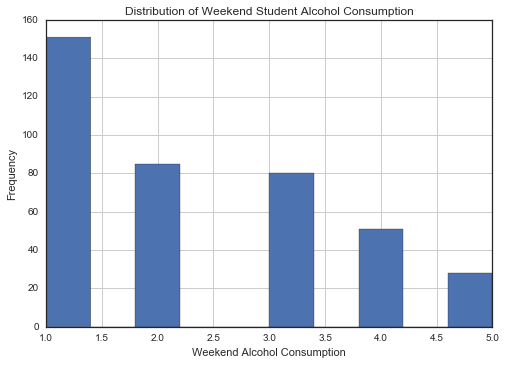

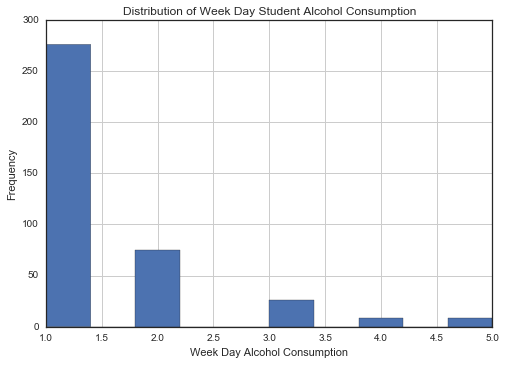

In [8]:
##EXPLORE DATA - TARGET VAR DISTRIBUTIONS

df.Walc.hist()
plt.xlabel('Weekend Alcohol Consumption')
plt.ylabel('Frequency')
plt.title('Distribution of Weekend Student Alcohol Consumption')
plt.show()

#more variability in the Walc target variable, less students drink during the week

df.Dalc.hist()
plt.xlabel('Week Day Alcohol Consumption')
plt.ylabel('Frequency')
plt.title('Distribution of Week Day Student Alcohol Consumption')
plt.show()

Notes:
- dataset is already curated and as a result no cleaning is required
- on to exploring variable importance....

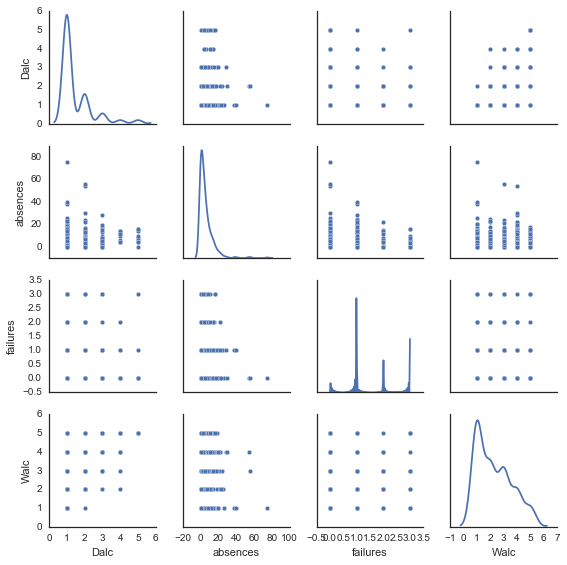

In [13]:
##LOOK AT VAR EFFECTS ON TARGET

# ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 
#	'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 
#	'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 
#    'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


sns.pairplot(df[['Dalc','absences','failures','Walc']], size=2, diag_kind="kde");

##note: univariate distributions are shown on diagonals
##note: because independent variables are coded some underlying trends are not shown as the frequency of each
###### coded variable cannot be seen on this pairplot

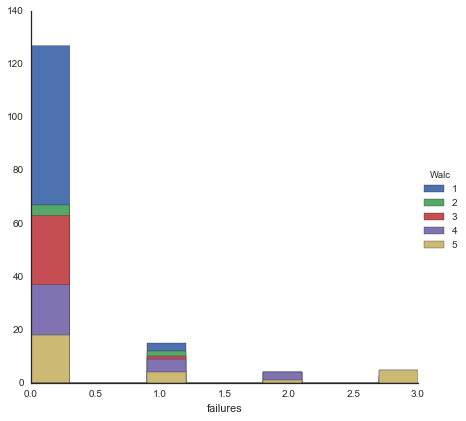

In [14]:
sns.FacetGrid(df, hue="Walc", size=6).map(plt.hist, "failures").add_legend()

##this plot does a better job of showing the relationship between failures and Walc

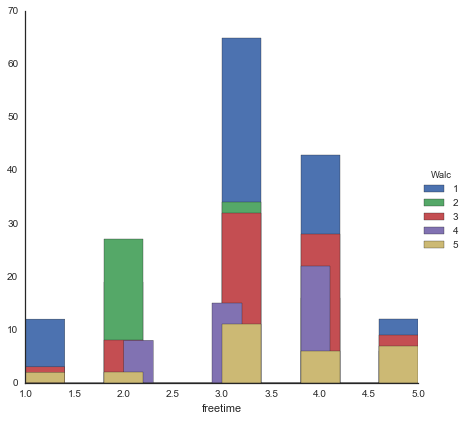

In [16]:
sns.FacetGrid(df, hue="Walc", size=6).map(plt.hist, "freetime").add_legend()

##higher frequency of high Walc with more free time

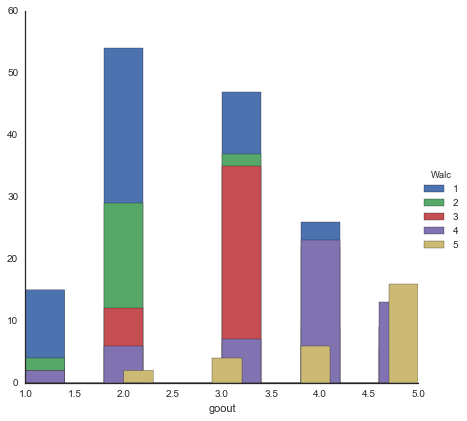

In [37]:
sns.FacetGrid(df, hue="Walc", size=6).map(plt.hist, "goout").add_legend()

##higher frequency of high Walc the more students go out

In [32]:
##Check p-values to see which variables 
##The p-value for each term tests the null hypothesis that the coefficient is equal to zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis. In other words, a predictor that has a low p-value is likely to be a meaningful addition to your model because changes in the predictor's value are related to changes in the response variable.
##Conversely, a larger (insignificant) p-value suggests that changes in the predictor are not associated with changes in the response.


x_vars=list(df.drop('Walc',axis=1).columns.values) 
Y=df['Walc'].values
X=df.drop('Walc',axis=1) #include all vars as predictors

#produce F scores and p-values
F,p_val=f_regression(X,Y)

#split variables into two groups; statistically significant and insignificant at the 95% confidence level
signif_vars={var_name:p for var_name,p in zip(x_vars,p_val) if p<0.05}
insignif_vars={var_name:p for var_name,p in zip(x_vars,p_val) if p>0.05}

signif_vars

{'Dalc': 2.5482027256862348e-48,
 'G1': 0.012078125598117216,
 'absences': 0.0066713923476575962,
 'address': 0.044577931518646273,
 'age': 0.019728095841255948,
 'failures': 0.0047011571664377031,
 'famrel': 0.024205043240665455,
 'famsize': 0.039924458743228593,
 'freetime': 0.0032318049948145671,
 'goout': 2.4016155113009122e-18,
 'higher': 0.04626993918904191,
 'nursery': 0.048060645839514013,
 'sex': 3.0467558305575007e-08,
 'studytime': 3.1907771897480739e-07,
 'traveltime': 0.0076050514248331424}

In [33]:
# Make a dataframe with the selected features and the target variable
X_sel = df[list(signif_vars.keys())+['Walc']]

In [34]:
cor_mat = X_sel.corr()

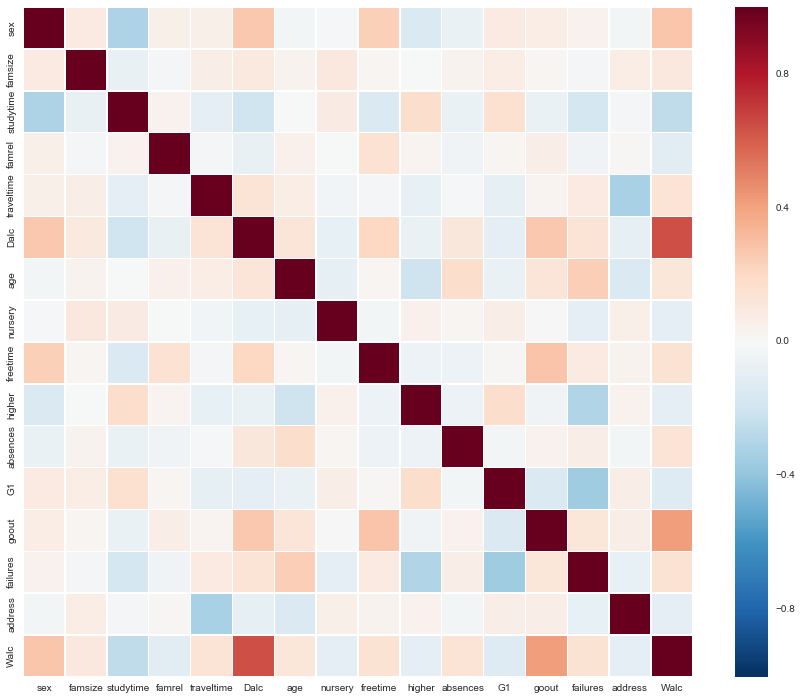

In [35]:
f, ax = plt.subplots(figsize=(15, 12))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cor_mat,linewidths=.5, ax=ax);

##Look along right most column....as shown Dalc, sex, goout all have strong positive correlations with Walc
###studytime has a strong negative correlation

In [50]:
#pearsonr func only takes one x var at a time
X_sel=df[list(signif_vars.keys())] #redefine X_sel so it doesn't include Walc
corr_dict={}
for feature in X_sel.keys():
    corr_dict[feature]={}
    corr_dict[feature]['pearsonr']=stats.pearsonr(X_sel[feature].values,Y)[0]
    corr_dict[feature]['pval']=signif_vars[feature]

corr_dict

{'Dalc': {'pearsonr': 0.64754423001800876, 'pval': 2.5482027256862348e-48},
 'G1': {'pearsonr': -0.1261792080381347, 'pval': 0.012078125598117216},
 'absences': {'pearsonr': 0.13629110147995085, 'pval': 0.0066713923476575962},
 'address': {'pearsonr': -0.10112568518670069, 'pval': 0.044577931518646273},
 'age': {'pearsonr': 0.11727605242651373, 'pval': 0.019728095841255948},
 'failures': {'pearsonr': 0.14196202998571511, 'pval': 0.0047011571664377031},
 'famrel': {'pearsonr': -0.11339730836657598, 'pval': 0.024205043240665455},
 'famsize': {'pearsonr': 0.10342500758219897, 'pval': 0.039924458743228593},
 'freetime': {'pearsonr': 0.14782181283995183, 'pval': 0.0032318049948145671},
 'goout': {'pearsonr': 0.42038574547178864, 'pval': 2.4016155113009122e-18},
 'higher': {'pearsonr': -0.10033961339145731, 'pval': 0.04626993918904191},
 'nursery': {'pearsonr': -0.099533525096382025, 'pval': 0.048060645839514013},
 'sex': {'pearsonr': 0.27419376658716194, 'pval': 3.0467558305575007e-08},
 's